# Online stochastic gradient descent with Thompson Sampling

https://arxiv.org/pdf/2006.04012

![formulas](./3_4.png)

![formulas](./5_6_7.png)


![formulas](./alg.png)


In [1]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class SGDTSBandit:
    def __init__(self, d, K=2, tau=100, alpha=5.0, R=1.0, c1=1.0, c3=0.25, T=10000):
        self.d = d
        self.K = K
        self.tau = tau
        self.alpha = alpha
        self.R = R
        self.c1 = c1
        self.c3 = c3
        self.T = T

        self.X_hist = []
        self.Y_hist = []
        
        self.t = 0
        self.theta_hat = None
        self.C_center = None
        self.C_radius = 2.0
        self.theta = None
        self.tilde_theta = []
        self.theta_ts = None
        self.j = 0
        
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    def __project_to_C(self, theta):

        delta = theta - self.C_center
        norm = np.linalg.norm(delta)

        if norm > self.C_radius:
            return self.C_center + self.C_radius * delta / norm
        else:
            return theta
    
    def __random_pull(self, X_arms):
        "Случайное действие в exploration-старте"
        return np.random.randint(self.K)
    
    def __collect_history(self, X, reward):
        "Сохраняем наблюдения"
        self.X_hist.append(X)
        self.Y_hist.append(reward)
    
    def __count_MLE(self):
        "MLE на первых tau шагах (по всей истории на этом этапе)"
        X_tau = np.array(self.X_hist)
        Y_tau = np.array(self.Y_hist)
        theta = np.zeros(self.d)

        lr = 0.1
        for _ in range(200):
            preds = self.sigmoid(X_tau @ theta)
            grad = -np.dot((Y_tau - preds), X_tau)
            theta -= lr * grad / self.tau
        return theta
    
    def __init_C_and_theta0(self, theta_hat):
        "Запуск: инициализация выпуклого множества и оценок SGD"
        self.C_center = theta_hat.copy()
        self.theta = theta_hat.copy()
        self.tilde_theta = [theta_hat.copy()]
        self.j = 1   # первое окно
    
    def __sgd_update(self):
        "Каждые tau раундов: один шаг SGD по последним tau наблюдениям"

        X_tau = np.array(self.X_hist[-self.tau:])
        Y_tau = np.array(self.Y_hist[-self.tau:])
        eta_j = 1 / (self.alpha * self.j)

        grad = np.zeros(self.d)

        for i in range(self.tau):
            grad += (-Y_tau[i] + self.sigmoid(X_tau[i] @ self.theta)) * X_tau[i]

        new_theta = self.theta - eta_j * grad
        self.theta = self.__project_to_C(new_theta)
        self.tilde_theta.append(self.theta.copy())
    
    def __get_means(self):
        "Вычисляем среднее по SGD-оценкам"
        return np.mean(self.tilde_theta, axis=0)
    
    def __sample_theta_ts(self):
        "Сэмплируем параметр для Thompson Sampling"
        j = self.j
        g1 = self.R / self.c1 * np.sqrt(self.d * (2 * np.log(1 + 2 * j * self.tau / self.d) + 2 * np.log(self.T))) #! (6)
        g2 = self.tau / self.alpha * np.sqrt(1 + np.log(j)) #! (7)
        A = ((2 * self.c3 * g1 ** 2) / (self.alpha * j) + 2 * g2 ** 2 / j) * np.eye(self.d) #! (5)
        theta_bar = self.__get_means()
        self.theta_ts = np.random.multivariate_normal(theta_bar, A)
        
    def select_arm(self, X_arms):
        self.t += 1
        
        # случайно выбираем arm первые tau шагов
        if self.t <= self.tau:
            return self.__random_pull(X_arms)
        
        # Каждые tau шагов: обновить SGD и Thompson Sampling
        if self.t % self.tau == 1:
            self.j += 1
            self.__sgd_update()

            self.__sample_theta_ts()
        
        preds = self.sigmoid(X_arms @ self.theta_ts)
        return np.argmax(preds)
    
    def update(self, X, reward):
        self.__collect_history(X, reward)
        
        if self.t == self.tau:
            theta_hat = self.__count_MLE()
            self.theta_hat = theta_hat.copy()
            self.__init_C_and_theta0(theta_hat)
            self.__sample_theta_ts()

In [6]:
# Загрузка данных
df = fetch_openml('mushroom', version=1, as_frame=True).frame
y = (df['class'] == 'p').astype(int)  # poisonous=1, edible=0
X = df.drop('class', axis=1)

ohe = OneHotEncoder(sparse_output=False)
X_ohe = ohe.fit_transform(X)
d = X_ohe.shape[1]
N = X_ohe.shape[0]


In [7]:
model = SGDTSBandit(d, K=2, tau=100, alpha=5.0, T=N)
cum_regret = []
total_regret = 0
num_iter = 3000

for t in range(num_iter):
    xi = X_ohe[t]

    contexts = np.vstack([xi, xi])  # две "arms" — обе с одним и тем же контекстом

    arm = model.select_arm(contexts)
    regret = int(arm != y.iloc[t])
    model.update(xi, regret)
    total_regret += regret
    
    cum_regret.append(total_regret)


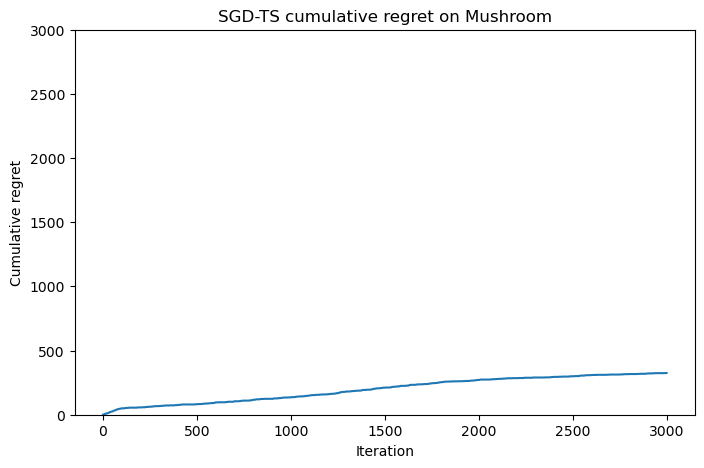

In [8]:
plt.figure(figsize=(8,5))
plt.plot(cum_regret)
plt.xlabel('Iteration')
plt.ylabel('Cumulative regret')
plt.title('SGD-TS cumulative regret on Mushroom')
plt.ylim(0, num_iter)
plt.show()